### Useful References
https://forum.pyro.ai/t/how-to-define-a-likelihood-function-in-numpyro/2968

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
import seaborn as sns

from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp
from jax import random, vmap

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_feasible, init_to_value

import scipy.stats

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import cel_utils.disk_utils as du
import scenario_generator.utils as u
from tqdm.auto import tqdm

In [20]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*2
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-10 2025-07-09


In [21]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=180), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=180), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=180), current_date)

smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp, smoothed_last_historical_rr, smoothed_last_historical_fpr)

5.9827728271484375 0.6902236183212552 0.8804779727859949


In [22]:
baseline = minting.compute_baseline_power_array(
    np.datetime64(current_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

In [23]:
storage_dir='input_hmc_RW'
save_dir = '/Users/kiran/Documents/baseline_project/'
os.makedirs(storage_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [62]:
def rw2ts(x_in, forecast_length, periodicity):
    """
    forecast_length - the total length of the time-series
    periodicity - the time-period after which a new sample from the random walk is drawn
    """
    x = jnp.repeat(x_in, periodicity)
    x = jnp.append(x, jnp.repeat(x[-1], forecast_length % periodicity))
    return x

In [75]:
sector_duration = 360
lock_target = 0.3
y = np.exp(lock_target) * jnp.ones(forecast_length)

# RW configuration
periodicity = 7 # every week allow an innovation of the RBP trajectory
nsteps = forecast_length // periodicity

def model():
    rbp_sample = numpyro.sample("rbp_exponent", dist.Beta(1, 10))
    rbp_trajectory = smoothed_last_historical_rbp*jnp.exp(jnp.arange(forecast_length) * rbp_sample)
    
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.5))  # models the variance on the observed lock target

    rr_trajectory = numpyro.sample('rr_RW', dist.GaussianRandomWalk(scale=1, num_steps=nsteps))
    rr_trajectory = rw2ts(rr_trajectory, forecast_length, periodicity)
    
    fpr_trajectory = numpyro.sample('fpr_RW', dist.GaussianRandomWalk(scale=1, num_steps=nsteps))
    fpr_trajectory = rw2ts(fpr_trajectory, forecast_length, periodicity)
    
    simulation_results = sim.run_sim(
        rbp_trajectory,
        rr_trajectory,
        fpr_trajectory,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    l = simulation_results['network_locked'][-forecast_length:]
    cs = simulation_results['circ_supply'][-forecast_length:]
    l_over_cs = jnp.nan_to_num(jnp.clip(l/cs, a_min = 0))
    numpyro.sample("L_over_CS_target", dist.LogNormal(l_over_cs, sigma), obs=y)

In [76]:
# @du.cache_data(directory=storage_dir)
def run_mcmc():
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    ref_params = {
        'rbp_exponent': np.log(2)/365,
        'sigma': 0.1
    }
    
    # Run NUTS.
    kernel = NUTS(model, init_strategy=init_to_value(values=ref_params))
    num_samples = 500
    mcmc = MCMC(kernel, num_warmup=500, num_samples=num_samples)
    mcmc.run(rng_key_)
    
    return {'mcmc': mcmc}

mcmc = run_mcmc()['mcmc']

sample: 100%|███████████████████████████████████████████████████████| 1000/1000 [59:11<00:00,  3.55s/it, 378 steps of size 1.34e-03. acc. prob=0.66]


In [87]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     fpr_RW[0]     -0.14      0.00     -0.14     -0.14     -0.14      3.34      2.25
     fpr_RW[1]      0.34      0.33      0.28     -0.11      0.77     14.47      1.02
     fpr_RW[2]      0.67      0.24      0.66      0.28      1.03     17.26      1.00
     fpr_RW[3]      0.47      0.18      0.46      0.19      0.78      9.87      1.09
     fpr_RW[4]      1.30      0.40      1.24      0.75      1.97      6.51      1.46
     fpr_RW[5]      0.99      0.23      0.99      0.63      1.33      3.49      2.03
     fpr_RW[6]      1.11      0.47      1.18      0.04      1.63      6.00      1.42
     fpr_RW[7]      0.64      0.25      0.63      0.26      1.02      6.31      1.12
     fpr_RW[8]      0.96      0.27      0.95      0.59      1.50     10.29      1.16
     fpr_RW[9]      1.12      0.37      1.23      0.57      1.74      3.54      1.55
    fpr_RW[10]      0.74      0.42      0.56      0.20      1.39

In [88]:
samps = mcmc.get_samples()

In [89]:
t = [current_date + timedelta(days=i) for i in range(forecast_length)]

<IPython.core.display.Javascript object>


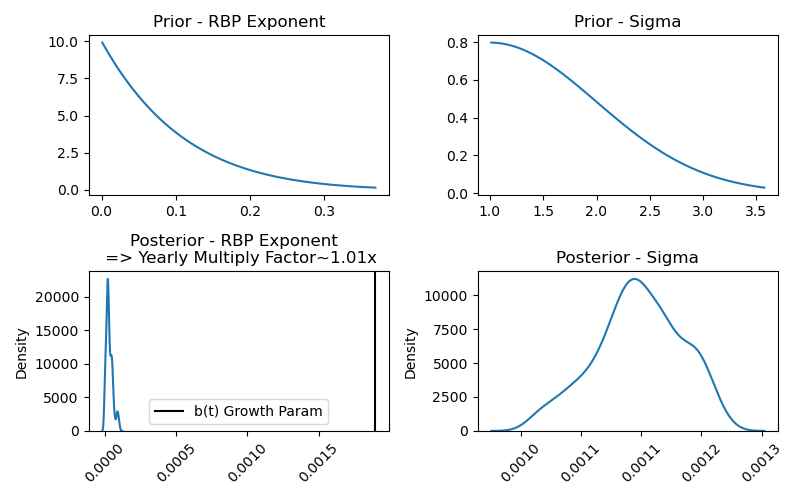

In [90]:
yearly_multiply_factor_approx = np.exp(np.mean(samps['rbp_exponent']) * 365)

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
a, b = 1, 10
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)
plt.plot(x, scipy.stats.beta.pdf(x, a, b))
plt.title('Prior - RBP Exponent')

plt.subplot(2,2,2)
mu, std = 1, 1
x = np.linspace(scipy.stats.halfnorm.ppf(0.01, mu, std),
                scipy.stats.halfnorm.ppf(0.99, mu, std), 100)
plt.plot(x, scipy.stats.halfnorm.pdf(x, mu, std))
plt.title('Prior - Sigma')

plt.subplot(2,2,3)
sns.kdeplot(samps['rbp_exponent'])
plt.title('Posterior - RBP Exponent  \n => Yearly Multiply Factor~%0.02fx' % (yearly_multiply_factor_approx,))
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.4f}"))
plt.xticks(rotation=45)
plt.axvline(np.log(2)/365, color='k', label='b(t) Growth Param')
plt.legend()


plt.subplot(2,2,4)
sns.kdeplot(samps['sigma'])
plt.title('Posterior - Sigma')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.4f}"))
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'dist.png'))

In [91]:
samps['rr_RW'].shape

(500, 104)

In [92]:
num_mc = 1000

keys_to_store = [
    'rb_total_power_eib',
    'qa_total_power_eib',
    'day_network_reward',
    'network_locked',
    'circ_supply',
    'l_over_cs'
]
# create arrays for each data to store
store_dict = {}
for k in keys_to_store:
    store_dict[k] = []
    
for i in tqdm(range(num_mc)):
    rbp_exponent = samps['rbp_exponent'][i]
    rbp_trajectory = smoothed_last_historical_rbp*jnp.exp(jnp.arange(forecast_length) * rbp_exponent)
    rr_trajectory = reconstitute_rw(samps['rr_RW'][i], forecast_length, periodicity)
    fpr_trajectory = reconstitute_rw(samps['fpr_RW'][i], forecast_length, periodicity)
#     rr_trajectory = jnp.ones(forecast_length) * smoothed_last_historical_rr
#     fpr_trajectory = jnp.ones(forecast_length) * smoothed_last_historical_fpr
    
    simulation_results = sim.run_sim(
        rbp_trajectory,
        rr_trajectory,
        fpr_trajectory,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    for k in keys_to_store:
        if k == 'l_over_cs':
            store_dict[k].append(simulation_results['network_locked'][-forecast_length:]/simulation_results['circ_supply'][-forecast_length:])
        else:
            store_dict[k].append(simulation_results[k][-forecast_length:])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [93]:
def compute_quantiles(x):
    qvec = [0.05, 0.25, 0.50, 0.75, 0.95]
    qs = np.quantile(x, qvec, axis=0)
    return qs

<IPython.core.display.Javascript object>


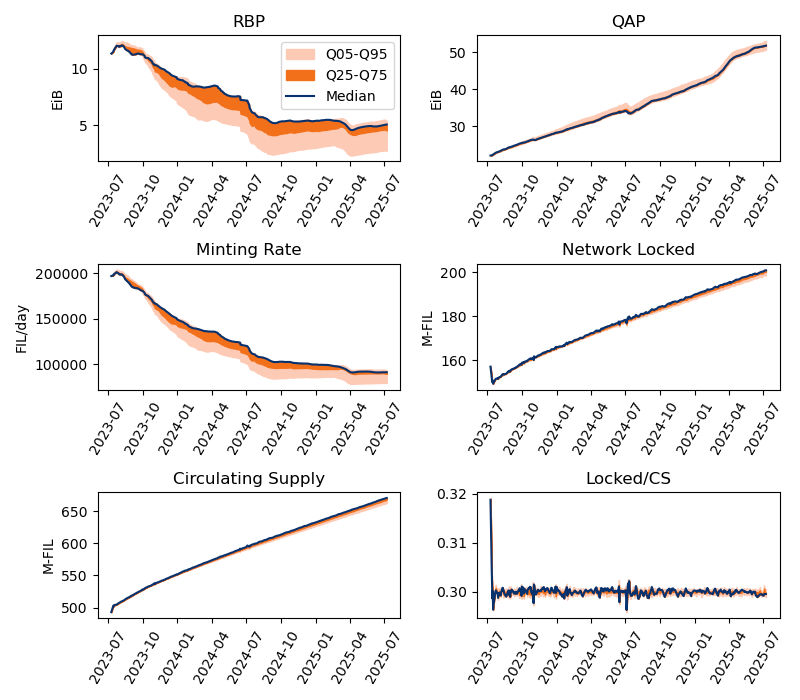

In [94]:
plt.figure(figsize=(8,7))

c_blue = mpl.colormaps['Blues']
c_orange = mpl.colormaps['Oranges']
c_red = mpl.colormaps['Reds']

k = 'rb_total_power_eib'
qs = compute_quantiles(np.asarray(store_dict[k]))
plt.subplot(3,2,1)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99), label='Median')
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('RBP')
plt.legend()

k = 'qa_total_power_eib'
qs = compute_quantiles(np.asarray(store_dict[k]))
plt.subplot(3,2,2)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('QAP')

k = 'day_network_reward'
qs = compute_quantiles(np.asarray(store_dict[k]))
plt.subplot(3,2,3)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')

k = 'network_locked'
qs = compute_quantiles(np.asarray(store_dict[k]))
plt.subplot(3,2,4)
plt.fill_between(t, qs[0]/1e6, qs[4]/1e6, color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1]/1e6, qs[3]/1e6, color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2]/1e6, color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('M-FIL')

k = 'circ_supply'
qs = compute_quantiles(np.asarray(store_dict[k]))
plt.subplot(3,2,5)
plt.fill_between(t, qs[0]/1e6, qs[4]/1e6, color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1]/1e6, qs[3]/1e6, color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2]/1e6, color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('M-FIL')

k = 'l_over_cs'
qs = compute_quantiles(np.asarray(store_dict[k]))
plt.subplot(3,2,6)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.xticks(rotation=60)
plt.title('Locked/CS')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'hmc.png'))

In [95]:
# manually generate the trajectories since each is unique
rbp_mat = []
rr_mat = []
fpr_mat = []
for i in tqdm(range(num_mc)):
    rbp_exponent = samps['rbp_exponent'][i]
    rbp_trajectory = smoothed_last_historical_rbp*jnp.exp(jnp.arange(forecast_length) * rbp_exponent)
    
    rbp_mat.append(rbp_trajectory)
    rr_mat.append(reconstitute_rw(samps['rr_RW'][i], forecast_length, periodicity))
    fpr_mat.append(reconstitute_rw(samps['fpr_RW'][i], forecast_length, periodicity))

rbp_mat = np.asarray(rbp_mat)
rr_mat = np.asarray(rr_mat)
fpr_mat = np.asarray(fpr_mat)


  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


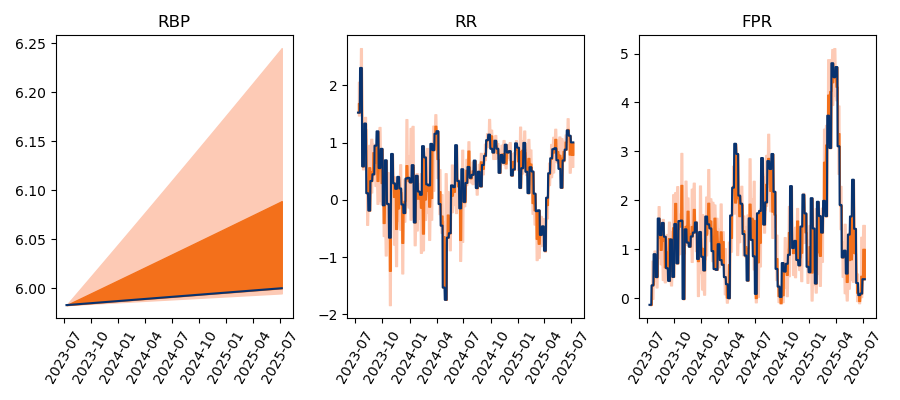

In [96]:
# Plot the input ranges
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
qs = compute_quantiles(rbp_mat)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.title('RBP')
plt.xticks(rotation=60)

plt.subplot(1,3,2)
qs = compute_quantiles(rr_mat)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.title('RR')
plt.xticks(rotation=60)

plt.subplot(1,3,3)
qs = compute_quantiles(fpr_mat)
plt.fill_between(t, qs[0], qs[4], color=c_red(0.2), label='Q05-Q95')
plt.fill_between(t, qs[1], qs[3], color=c_orange(0.6), label='Q25-Q75')
plt.plot(t, qs[2], color=c_blue(0.99))
plt.title('FPR')
plt.xticks(rotation=60)

plt.tight_layout()